## Exploring Strategies with Distributed Data

1. Work with **all** of the data with **spark**

    \+ most accurate reports    
    \- limited by the operations that spark provides, e.g. visualization. 


2. Work with a **sample** of the data with **pandas**

    \+ This lets us use the tools we are already familiar with to explore the data  
    \+ More visualization options  
    \+ Faster iteration   
    \- We are working with a sample, and not the entire data, so we could be missing information.  


3. **Aggregate** the data with **spark**, and then work with the aggregated data locally with **Pandas**

    \+ We won't "miss out" on anything like we have the potential to do when working with sampled data  
    \+ Benefits of working locally in the pandas ecosystem   
    \- However, we are limited by the fact that we have to do aggregation, which usually results in a different shape of data, and information is lost when aggregating.  

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                


## Strategy 1: Work with all the data using Spark

In [2]:
# How many open and closed cases are there?

In [3]:
sdf = df
sdf.groupby("case_status").count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



In [4]:
# What is the avg time a case is open?

In [5]:
sdf.groupby("case_status").agg(mean("case_lifetime")).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108263294778737|
+-----------+------------------+



## Strategy 2: Work with a sample of the data with Pandas

In [6]:
pdf = sdf.sample(fraction=0.05, seed= 123).toPandas()

In [7]:
print(pdf.shape)
pdf.head()

(42159, 20)


,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127400,2018-01-01 09:30:00,2018-01-02 16:00:00,2018-01-06 09:30:00,False,-3.729525,True,Animal Neglect,5.000000,Closed,139344,"254 GLOBE AVE, San Antonio, 78228",007,-0.532789,78228,219,1.0,1,Animal Care Services,True
2,1014127419,2018-01-01 10:37:00,2018-02-11 14:32:00,2018-01-06 10:37:00,True,36.163079,True,Aggressive Animal(Non-Critical),5.000000,Closed,ns16326,"436 SAN HORACIO S, San Antonio, 78237",005,5.166154,78237,219,41.0,41,Animal Care Services,True
3,1014127444,2018-01-01 11:23:00,2018-01-01 11:39:00,2018-01-01 14:23:00,False,-0.114120,True,Animal Cruelty(Critical),0.125000,Closed,svcCRMSS,PRENTISS DR and PRESLEY DR,007,-0.016303,,219,0.0,0,Animal Care Services,True
4,1014127473,2018-01-01 12:37:00,2018-01-03 14:10:00,2018-01-02 00:37:00,True,1.564792,True,Trapped/Confined Animal,0.500000,Closed,139344,"5470 MILITARY DR W, San Antonio, 78242",004,0.223542,78242,219,2.0,2,Animal Care Services,True


In [8]:
numeric_cols = ["num_days_late", "SLA_days", "num_weeks_late", "case_age", "days_to_closed", "case_lifetime"]

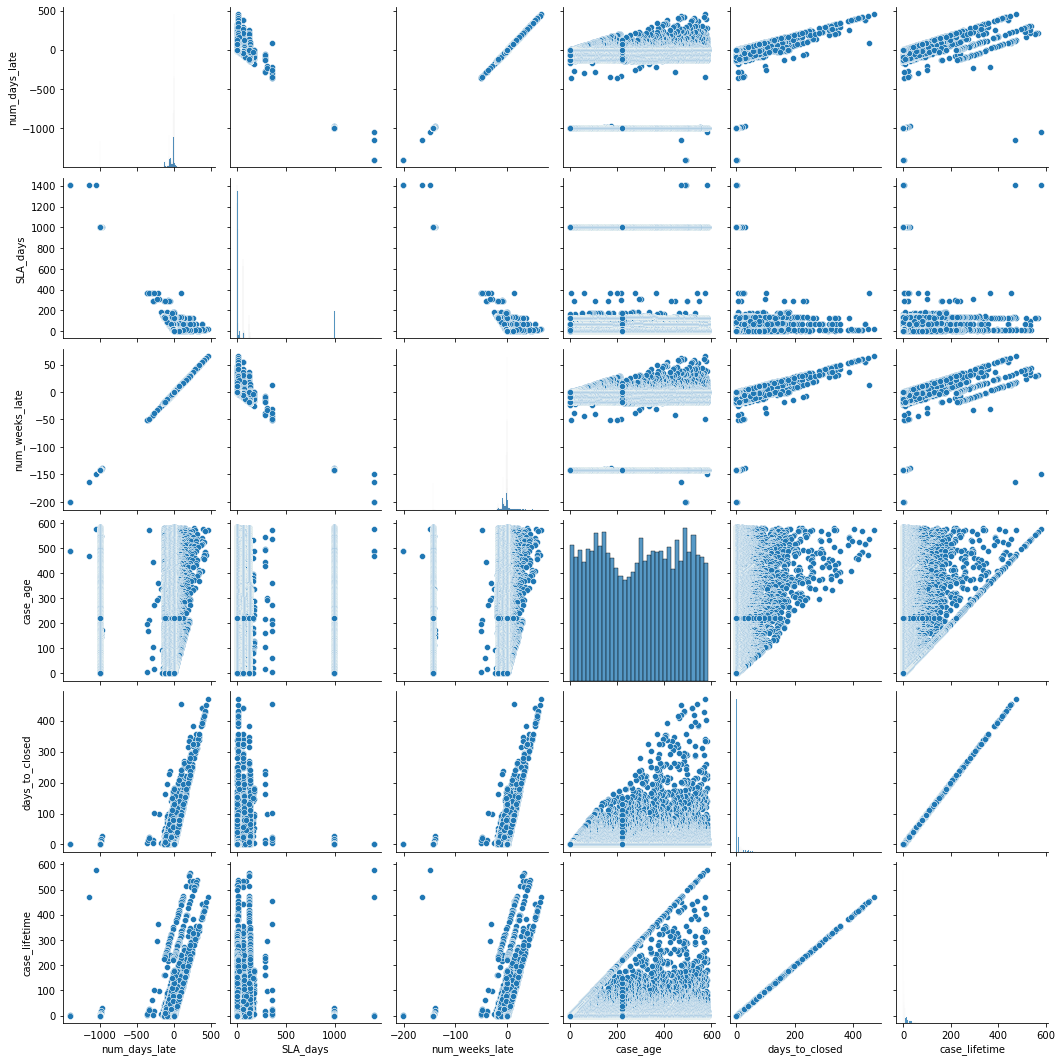

In [9]:
sns.pairplot(pdf[numeric_cols])

<AxesSubplot:ylabel='Frequency'>

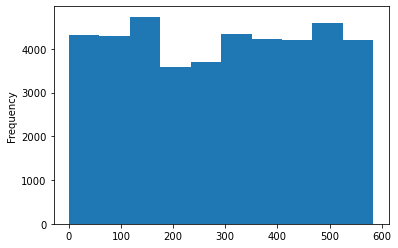

In [10]:
pdf.case_age.plot.hist()

<AxesSubplot:xlabel='department', ylabel='case_late'>

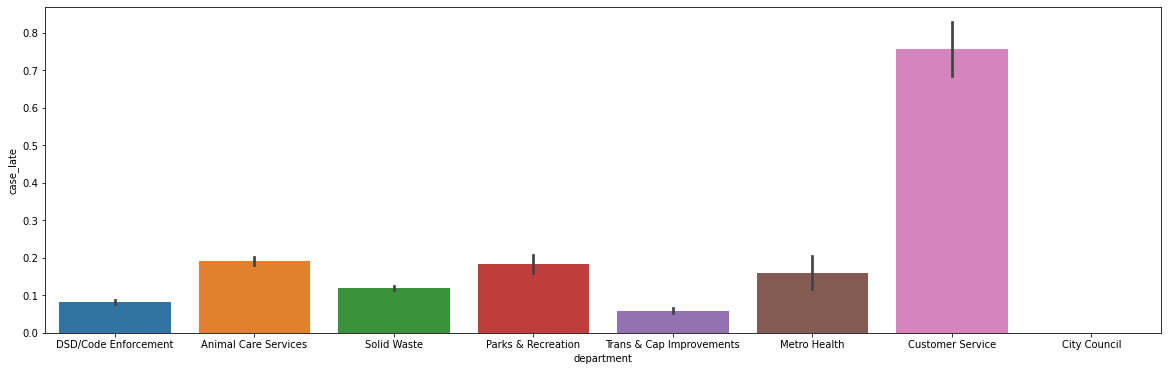

In [11]:
plt.figure(figsize =(20, 6))
sns.barplot(pdf.department, pdf.case_late)

## Strategy 3: Aggregate with spark, and then work with the aggregated data using Pandas

In [12]:
# What does the case lifetime look like for each department?

In [13]:
df.groupby('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



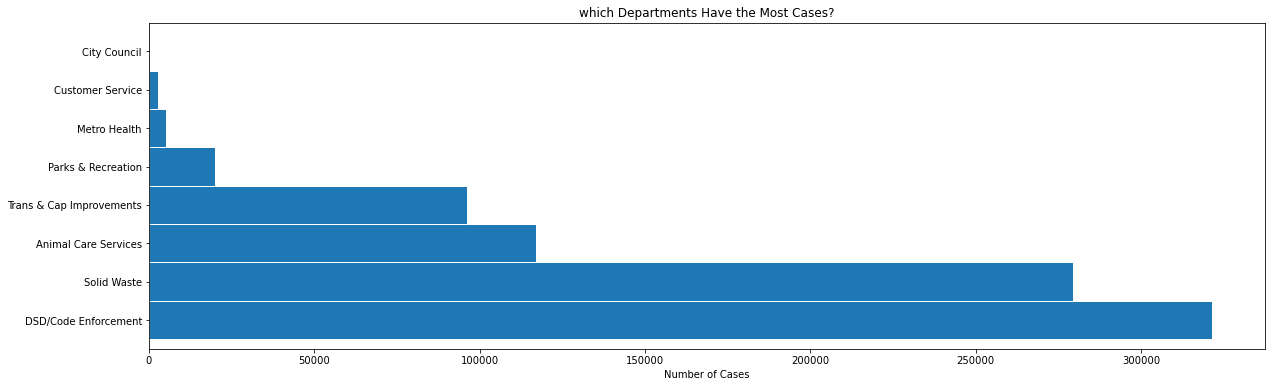

In [14]:
(
    sdf.groupby('department')
    .count()
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending = False)
    .plot.barh(width = 1, edgecolor = "white", figsize = (20, 6))
)

plt.title("which Departments Have the Most Cases?")
plt.ylabel("")
plt.xlabel("Number of Cases")
plt.show()

In [15]:
# What does the case lifetime look like for each department?

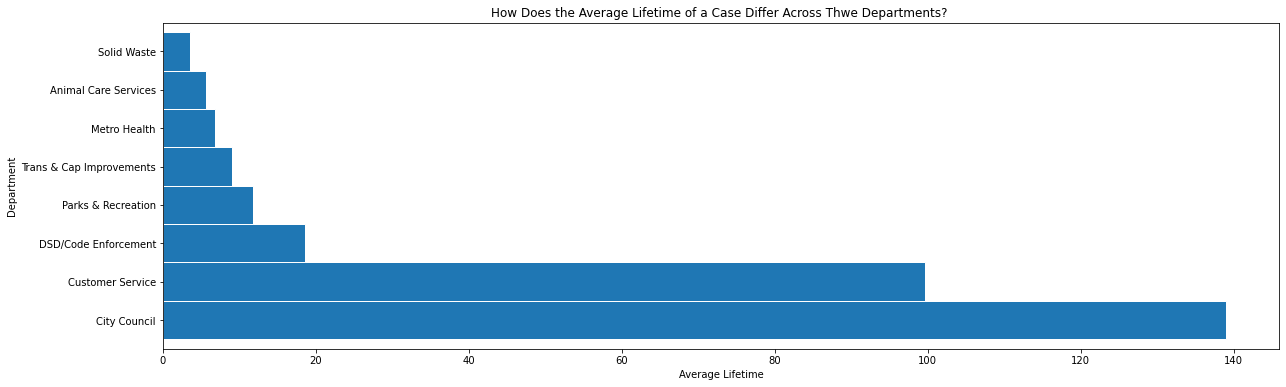

In [16]:
(
    sdf.groupby('department')
    .agg(mean("case_lifetime").alias("avg_lifetime"))
    .toPandas()
    .set_index("department")
    .avg_lifetime.sort_values(ascending = False)        
    .plot.barh(width = 1, edgecolor = "white", figsize = (20, 6))
)

plt.title("How Does the Average Lifetime of a Case Differ Across Thwe Departments? ")
plt.ylabel("Department")
plt.xlabel("Average Lifetime")
plt.show()

In [17]:
# Let's control for case status and then look at case lifetime for each department. So then we can look at,
# of the closed cases, which ones had the longest/shortes lives.

In [49]:
(
    df.groupby("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("Closed")
    .show(truncate = False)
    .select('department', "closed")
    .toPandas()
    .set_index('department')
    .plot.barh(width = 1,edgecolor = "white", figsize = (20, 6))

)

plt.title("How does the time to reslove cases differ acrosss departments\n when analyizing those cases?")
plt.ylabel("Department")
plt.xlabel("Average Case Lifetime")
plt.show()

+------------------------+------+------+
|department              |Closed|Open  |
+------------------------+------+------+
|Solid Waste             |3.4   |16.45 |
|Animal Care Services    |5.51  |21.36 |
|Metro Health            |6.82  |4.64  |
|Trans & Cap Improvements|8.0   |54.39 |
|Parks & Recreation      |10.66 |64.72 |
|DSD/Code Enforcement    |15.64 |91.56 |
|City Council            |29.25 |154.07|
|Customer Service        |48.94 |172.94|
+------------------------+------+------+



AttributeError: 'NoneType' object has no attribute 'select'

In [ ]:
cases_by_day = sdf.select("department", 
                          date_format("case_opened_date", 
                                      "yyyy-MM-dd").alias("case_opened_date"),
                          date_format("case_closed_date",
                                      "yyyy-MM-dd").alias("case_closed_date")
                         )
cases_by_day.show(5)

In [36]:
cases_opened_by_day = (
    cases_by_day
    .groupby("case_opened_date")
    .count()
    .na.drop()
    .sort("case_opened_date")
    .toPandas()
    .assign(case_opened_date = lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')['count']
)

cases_opened_by_day.name= 'cases_opened'

In [37]:
cases_closed_by_day = (
    cases_by_day
    .groupby("case_closed_date")
    .count()
    .na.drop()
    .sort("case_closed_date")
    .toPandas()
    .assign(case_opened_date = lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')['count']
)

cases_closed_by_day.name= 'cases_closed'


In [38]:
pdf = pd.concat([cases_opened_by_day, cases_closed_by_day], axis= 1)
pdf.head()

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173


<AxesSubplot:>

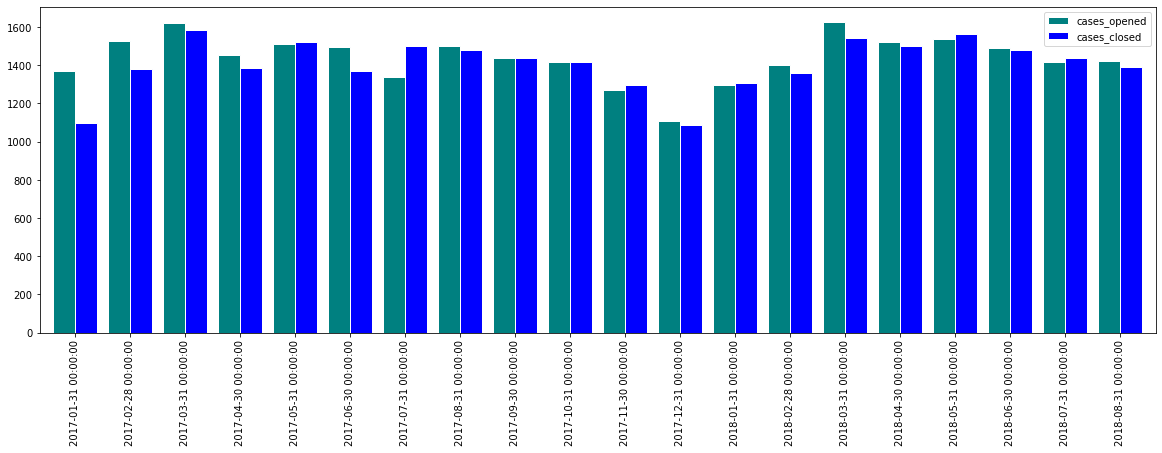

In [44]:
pdf.resample('M').mean().plot.bar(figsize = (20, 6), width = .8, ec = "white", color  =["teal", "blue"])
